In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [2]:
# 1. Inlezen
df = pd.read_excel("NH4influentfile.xlsx", sheet_name="Blad1")

# 2. Zet 'MiddleHour' om naar tijd-formaat (HH:MM:SS → datetime.time)
df["MiddleHour"] = pd.to_datetime(df["MiddleHour"], format="%H:%M:%S", errors="coerce").dt.time

# 3. Zet 'Date' naar datetime (indien nog niet)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# 4. Combineer tot volledige datetime
df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["MiddleHour"].astype(str),
                                format="%Y-%m-%d %H:%M:%S", errors="coerce")

# ✅ Resultaat
print(df[["Date", "MiddleHour", "Datetime"]].head())

        Date MiddleHour            Datetime
0 2023-10-04   13:00:00 2023-10-04 13:00:00
1 2023-10-11   13:00:00 2023-10-11 13:00:00
2 2023-10-16   10:15:00 2023-10-16 10:15:00
3 2023-10-18   11:00:00 2023-10-18 11:00:00
4 2023-10-23   10:15:00 2023-10-23 10:15:00


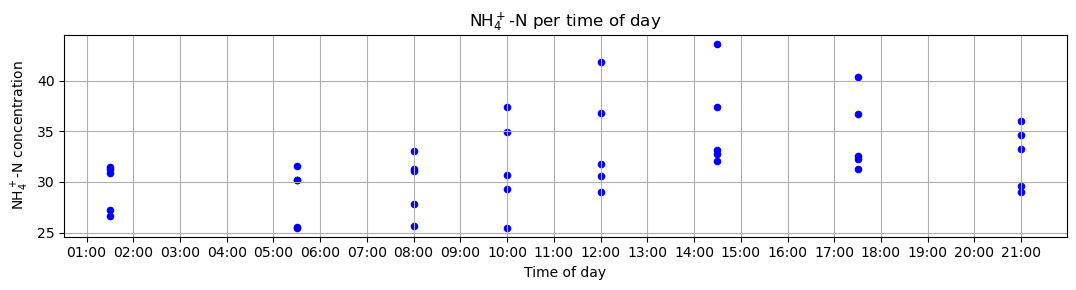

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Gebruik dezelfde df_cyclus als jij
df_cyclus = df[df["Time"].notna() & df["NH3-N"].notna()].copy()
df_cyclus["Minutes"] = df_cyclus["MiddleHour"].apply(lambda t: t.hour * 60 + t.minute + t.second / 60)

# Plot met HH:MM als labels op x-as
plt.figure(figsize=(11, 3))
plt.scatter(df_cyclus["Minutes"], df_cyclus["NH3-N"], color='blue', s=20)

# Formatter voor de x-as in HH:MM
def format_minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(60))  # 1 label per uur
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_minutes_to_hhmm))

plt.xlabel("Time of day")
plt.ylabel("NH$_4^+$-N concentration")
plt.title("NH$_4^+$-N per time of day")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

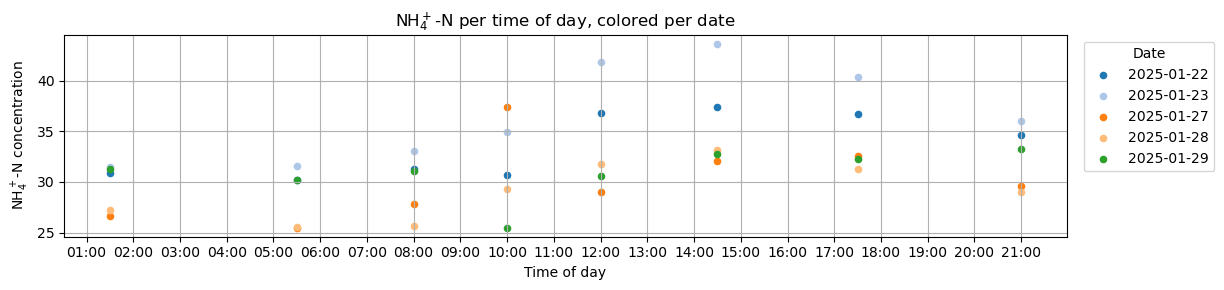

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Filter en voeg kolommen toe
df_cyclus = df[df["Time"].notna() & df["NH3-N"].notna()].copy()
df_cyclus["Date"] = df_cyclus["Date"].dt.date  # Alleen de datumcomponent
df_cyclus["Minutes"] = df_cyclus["MiddleHour"].apply(lambda t: t.hour * 60 + t.minute + t.second / 60)

# Unieke kleuren toekennen per dag
unique_dates = df_cyclus["Date"].unique()
color_map = {date: plt.cm.tab20(i % 20) for i, date in enumerate(unique_dates)}  # max 20 kleuren uit colormap

# Plot
plt.figure(figsize=(11, 3))
for date in unique_dates:
    subset = df_cyclus[df_cyclus["Date"] == date]
    plt.scatter(subset["Minutes"], subset["NH3-N"], color=color_map[date], s=20, label=str(date))

# Formatter voor x-as in HH:MM
def format_minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_minutes_to_hhmm))

plt.xlabel("Time of day")
plt.ylabel("NH$_4^+$-N concentration")
plt.title("NH$_4^+$-N per time of day, colored per date")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Optioneel: legende tonen (alleen als er weinig dagen zijn)
if len(unique_dates) <= 10:
    plt.legend(title="Date", bbox_to_anchor=(1.01, 1), loc="upper left")

plt.show()

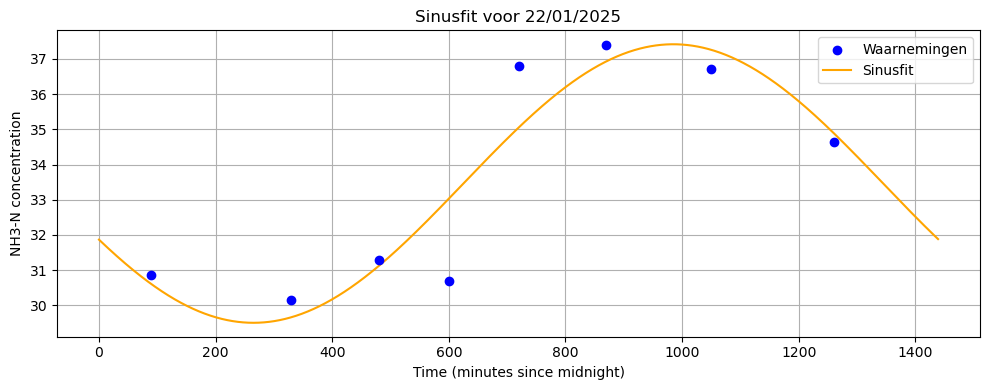

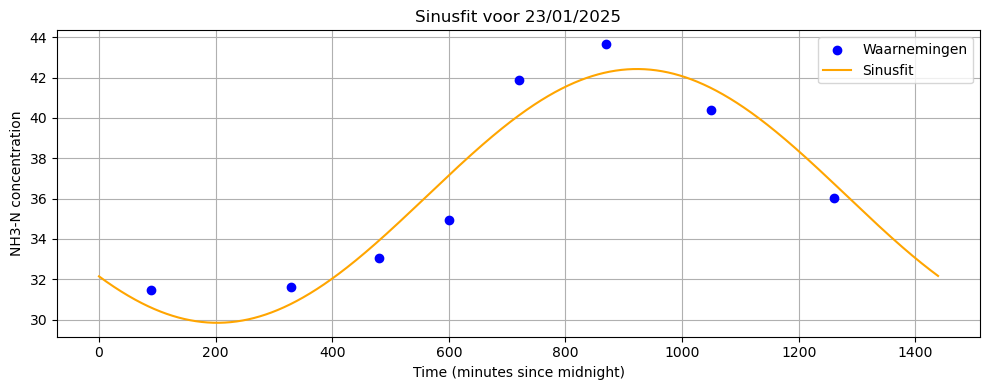

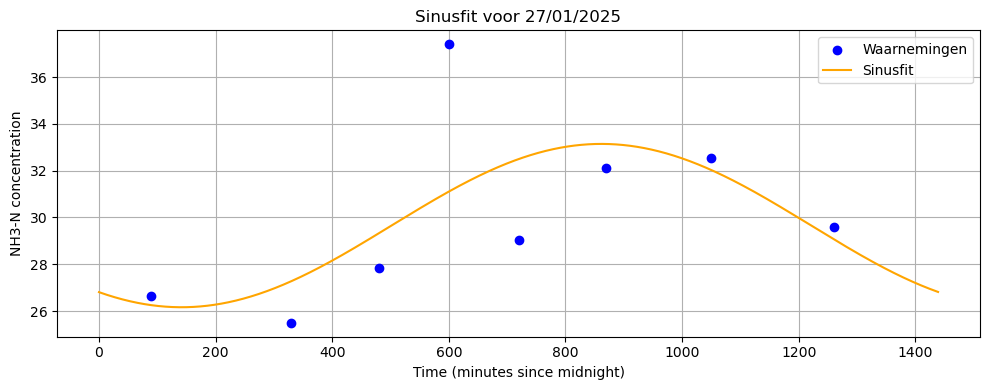

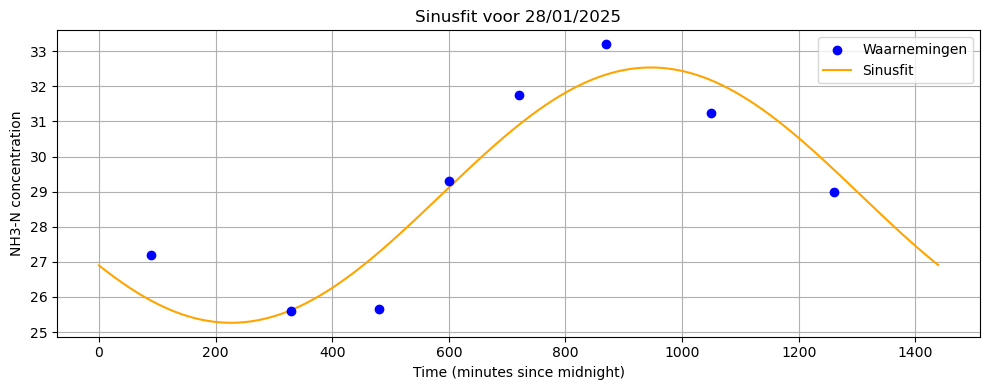

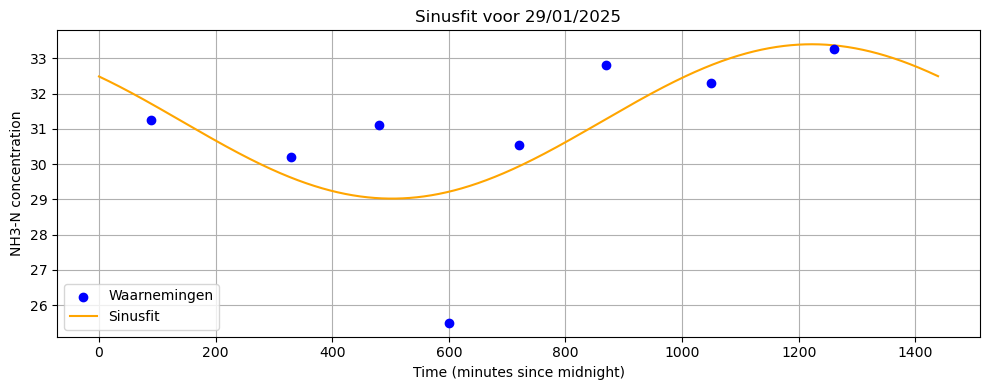

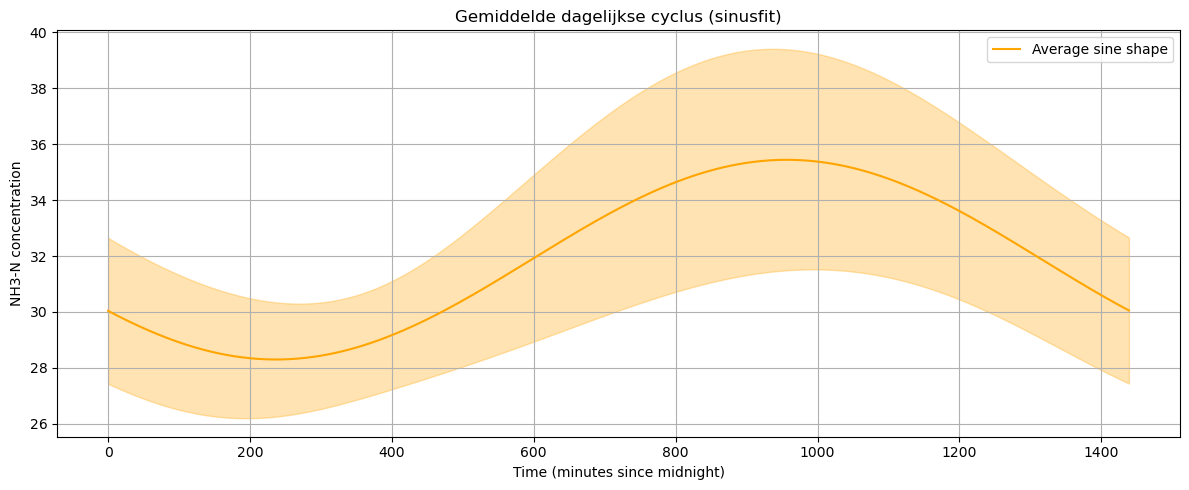

In [5]:
# De sinusfunctie
def daily_sinus(t, A, phi, C):
    return A * np.sin(2 * np.pi * t / 1440 + phi) + C

params_list = []
time_grid = np.arange(0, 1440, 1)
predictions_per_day = []

for date, group in df_cyclus.groupby("Date"):
    if len(group) < 3:
        continue

    t = group["Minutes"].values
    y = group["NH3-N"].values
    guess = [ (max(y)-min(y))/2, 0, np.mean(y) ]

    try:
        popt, _ = curve_fit(daily_sinus, t, y, p0=guess)
        params_list.append((date, *popt))
        y_fit = daily_sinus(time_grid, *popt)
        predictions_per_day.append(y_fit)

        # 🔍 Plot individuele fit + datapunten
        plt.figure(figsize=(10, 4))
        plt.scatter(t, y, color='blue', label="Waarnemingen", zorder=3)
        plt.plot(time_grid, y_fit, color='orange', label="Sinusfit", zorder=2)
        plt.title(f"Sinusfit voor {date.strftime('%d/%m/%Y')}")
        plt.xlabel("Time (minutes since midnight)")
        plt.ylabel("NH3-N concentration")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError:
        continue

predictions_per_day = np.array(predictions_per_day)
mean_curve = np.nanmean(predictions_per_day, axis=0)
std_curve = np.nanstd(predictions_per_day, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(time_grid, mean_curve, label="Average sine shape", color='orange')
plt.fill_between(time_grid, mean_curve - std_curve, mean_curve + std_curve, alpha=0.3, color='orange')
plt.xlabel("Time (minutes since midnight)")
plt.ylabel("NH3-N concentration")
plt.title("Gemiddelde dagelijkse cyclus (sinusfit)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import pandas as pd

# 🔁 Herdefinieer 10-minuten time grid
time_grid = np.arange(0, 1440, 10)  # 0 min → 1430 min
mean_curve = mean_curve[::10]  # als je vorige curve per minuut was

# 🔧 Helperfunctie
# Functie om cyclus verticaal te verschuiven
def reconstruct_cycle_from_y0(y0, template_curve):
    offset = y0 - template_curve[0]
    return template_curve + offset

# Hergebruik je dataframe df dat labodata bevat
df_lab = df.copy()
df_lab['Datetime'] = pd.to_datetime(df_lab['Datetime'])
df_lab = df_lab[df_lab["NH3-N"].notna()].copy()
df_lab = df_lab.set_index('Datetime').sort_index()

# Interpoleer over tijd
df_interp = df_lab['NH3-N'].resample("10min").mean().interpolate("time")

# Definieer alle dagen
all_days = pd.date_range(start="2023-10-25", end="2025-02-19", freq="D")

# Bouw gereconstrueerde curven
reconstructed_curves = []
dates_used = []

for date in all_days:
    same_day = df_lab[df_lab.index.date == date.date()]

    if not same_day.empty:
        t_lab = same_day.index[0]
        y_lab = same_day.iloc[0]["NH3-N"]
        t_minutes = t_lab.hour * 60 + t_lab.minute
        idx_closest = np.argmin(np.abs(time_grid - t_minutes))
        y_on_mean = mean_curve[idx_closest]
        offset = y_lab - y_on_mean
        curve = mean_curve + offset
    else:
        midnight = pd.Timestamp(date.strftime("%Y-%m-%d 00:00"))
        if midnight in df_interp.index:
            y0 = df_interp.loc[midnight]
            curve = reconstruct_cycle_from_y0(y0, mean_curve)
        else:
            continue

    reconstructed_curves.append(curve)
    dates_used.append(date)

In [7]:
from datetime import datetime, timedelta

# Functie om minuten sinds middernacht om te zetten naar HH:MM tijd
def minutes_to_time(minutes):
    return (datetime(2000, 1, 1) + timedelta(minutes=int(minutes))).time()

# Zet alle curves om naar rijen met Date, Time, NH3-N
records = []

for curve, date in zip(reconstructed_curves, dates_used):
    for t_min, nh3 in zip(time_grid, curve):
        records.append({
            "Date": pd.to_datetime(date).date(),
            "Time": minutes_to_time(t_min),
            "NH3-N": nh3
        })

# Maak de uiteindelijke DataFrame
df_reconstructed = pd.DataFrame(records)

# Preview
print(df_reconstructed.head())

         Date      Time      NH3-N
0  2023-10-25  00:00:00  24.151349
1  2023-10-25  00:10:00  24.019445
2  2023-10-25  00:20:00  23.891275
3  2023-10-25  00:30:00  23.767085
4  2023-10-25  00:40:00  23.647110


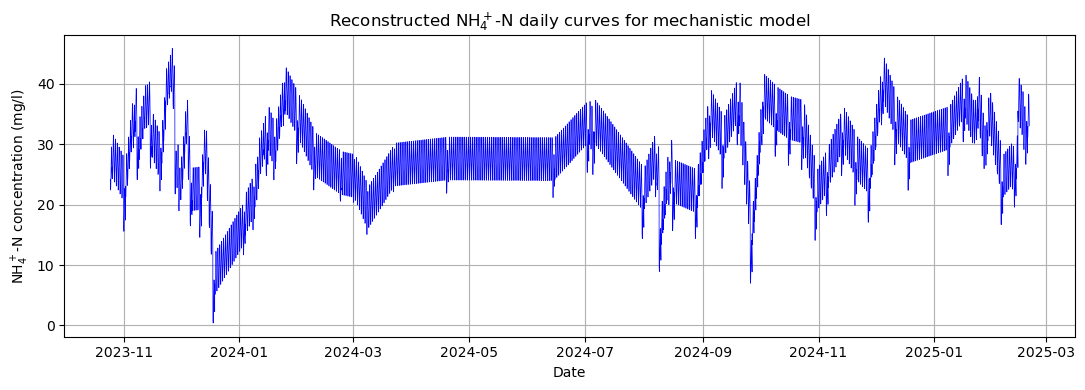

In [24]:
import matplotlib.pyplot as plt

# Combineer Date + Time tot één datetime-as
df_reconstructed['Datetime'] = pd.to_datetime(df_reconstructed['Date'].astype(str) + " " + df_reconstructed['Time'].astype(str))

# Sorteer voor de zekerheid
df_reconstructed = df_reconstructed.sort_values("Datetime")

# Plot
plt.figure(figsize=(11, 4))
plt.plot(df_reconstructed["Datetime"], df_reconstructed["NH3-N"], color='b', linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("NH$_4^+$-N concentration (mg/l)")
plt.title("Reconstructed NH$_4^+$-N daily curves for mechanistic model")
plt.grid(True)
plt.tight_layout()
plt.savefig("NH4influentdata.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [25]:
import pandas as pd

dflabo = pd.read_excel('LaboPython.xlsx', sheet_name='Blad2')
dflabo['ratioN'] = dflabo['TNprimeff'] / dflabo['NH4primeff']
mean_ratioN = dflabo['ratioN'].mean()

df_reconstructed['TKN'] = df_reconstructed['NH3-N'] * mean_ratioN
df_reconstructed = df_reconstructed[['Datetime', 'TKN']]

# Opslaan in CSV
df_reconstructed.to_csv("TKN_cycli.csv", index=False)

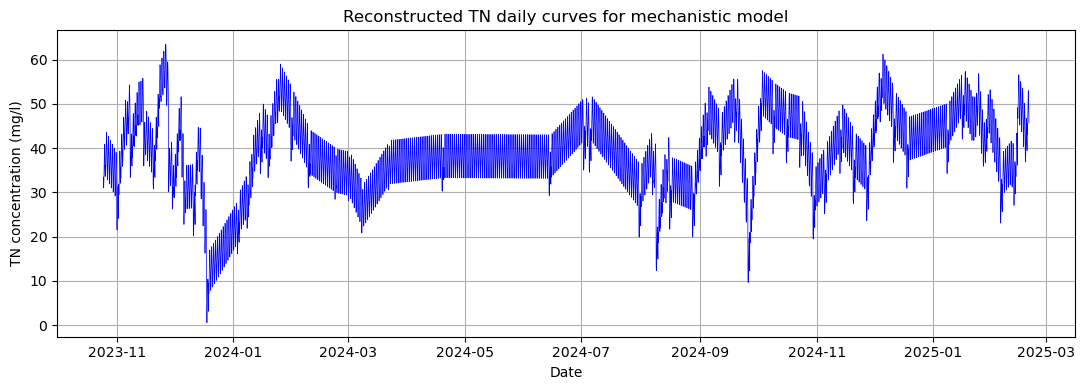

In [26]:
import matplotlib.pyplot as plt

# Sorteer voor de zekerheid
df_reconstructed = df_reconstructed.sort_values("Datetime")

# Plot
plt.figure(figsize=(11, 4))
plt.plot(df_reconstructed["Datetime"], df_reconstructed["TKN"], color='b', linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("TN concentration (mg/l)")
plt.title("Reconstructed TN daily curves for mechanistic model")
plt.grid(True)
plt.tight_layout()
plt.savefig("TNinfluentdata.pdf", format='pdf', bbox_inches='tight')
plt.show()

/var/folders/9f/th88wdx51hg0ndwms7rmbwbm0000gn/T/ipykernel_20261/940722988.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis", n)


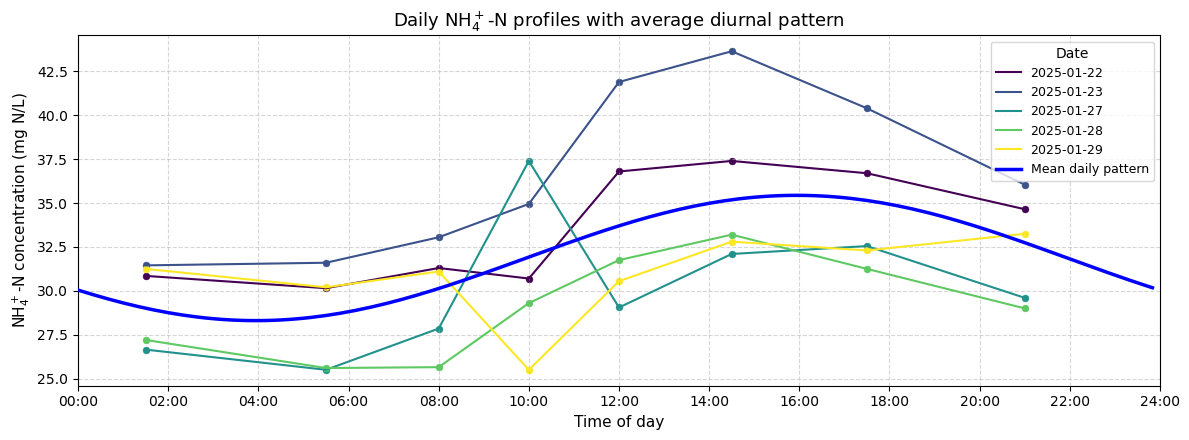

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import numpy as np

# Viridis-kleuren genereren (aantal = # dagen)
n = len(unique_dates)
viridis = cm.get_cmap("viridis", n)
kleuren = [viridis(i) for i in range(n)]

# Plot starten
plt.figure(figsize=(12, 4.5))

# Dagelijkse curves
for i, date in enumerate(unique_dates):
    subset = df_cyclus[df_cyclus["Date"] == date].sort_values("Minutes")
    plt.plot(subset["Minutes"], subset["NH3-N"], color=kleuren[i], linewidth=1.5, label=str(date))
    plt.scatter(subset["Minutes"], subset["NH3-N"], color=kleuren[i], s=25, linewidth=0.3)

# Mean curve in blauw met std-band
plt.plot(time_grid, mean_curve, color='blue', linewidth=2.5, label="Mean daily pattern", zorder=10)
#plt.fill_between(time_grid, mean_curve - std_curve, mean_curve + std_curve,
                 #alpha=0.2, color='blue', label="±1 std. dev.", zorder=0)

# Formatter voor HH:MM
def format_minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(120))  # alleen labels om de 2 uur
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_minutes_to_hhmm))

# Aslabels en opmaak
plt.xlabel("Time of day", fontsize=11)
plt.ylabel("NH$_4^+$-N concentration (mg N/L)", fontsize=11)
plt.title("Daily NH$_4^+$-N profiles with average diurnal pattern", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

# Legende
plt.legend(title="Date", loc="upper right", fontsize=9, title_fontsize=10)

# Layout en tonen
plt.xticks(rotation=0)
plt.xlim(0, 1440)
plt.tight_layout()
plt.savefig("NH4dailycycle.pdf", format='pdf', bbox_inches='tight')
plt.show()
